In [1]:
import sys
from pathlib import Path

# Notebook ka folder
NOTEBOOK_DIR = Path().resolve()

# Project root = parent folder
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Add project root to import path
sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)


Project root: D:\Langchain_LangGraph_03-12-2025\MyProject


In [2]:
#now importing all the Module which is used to build the AI Model.
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from exception import CustomException
from logger_config import logger
import os,sys

#using openai chat model and embedding models
from langchain_openai import ChatOpenAI,OpenAIEmbeddings

#using groq chat model 
from langchain_groq import ChatGroq

#using open source chat model from hugging Face
from langchain_huggingface import ChatHuggingFace,HuggingFaceEmbeddings,HuggingFaceEndpoint

from config import *

from langchain_core.runnables import RunnableBranch,RunnableLambda,RunnableParallel,RunnableSequence,RunnablePassthrough

[2025-12-05 00:54:53,779]-config_variable.py-INFO -Loading the environment Variable
[2025-12-05 00:54:53,782]-config_variable.py-INFO -Environment Variable successfully Loaded


In [3]:
%pwd

'd:\\Langchain_LangGraph_03-12-2025\\MyProject\\notebooks'

In [4]:
#import Langgraph related Modules
import langgraph
from langgraph.graph import StateGraph,START,END
from dataclasses import dataclass
from typing import TypedDict
from typing import Literal,List,Annotated
from langchain_core.messages import AnyMessage,AIMessage,HumanMessage,ToolMessage

from pydantic import BaseModel #using this class we can perform validation to schema

from langgraph.prebuilt import tool_node,tools_condition #in this class we put all tools together
#tools_condition wrt to tool msg it will route the flow data to ttol node to perform execution

from langchain_core.tools import tool,Tool,StructuredTool

from langgraph.graph.message import BaseMessage #this is special class which hold every mesaage init.



## step:1) defining the models components

In [5]:
model1 = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.2 #we call as creative parameter
)
model1

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001C97B9190C0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001C97AF18970>, root_client=<openai.OpenAI object at 0x000001C97BA8BBB0>, root_async_client=<openai.AsyncOpenAI object at 0x000001C97BF79120>, temperature=0.2, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [6]:
model2 = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.2 #we call as creative parameter
)
model2

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001C97C0720B0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001C97C0A89A0>, model_name='llama-3.1-8b-instant', temperature=0.2, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm = HuggingFaceEndpoint(  
repo_id="meta-llama/Llama-3.1-8B-Instruct",  
task="text-generation",  
max_new_tokens=512,  
do_sample=False,  
repetition_penalty=1.03,  
)  

model3 = ChatHuggingFace(llm=llm, verbose=True)
model3

ChatHuggingFace(llm=HuggingFaceEndpoint(repo_id='meta-llama/Llama-3.1-8B-Instruct', repetition_penalty=1.03, stop_sequences=[], server_kwargs={}, model_kwargs={}, model='meta-llama/Llama-3.1-8B-Instruct', client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, async_client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, task='text-generation'), model_id='meta-llama/Llama-3.1-8B-Instruct', model_kwargs={})

## building different type of complex workflows using LangGraph

### 1) building Parallel workflow

#### defining state or memory schema for this workflow

In [8]:

class CricketState(TypedDict):
    runs : int
    total_ball_played_innings : int
    total_4s_innings : int
    total_6s_innings : int
    strike_rate : float| None
    boundary_perc : float | None
    balls_per_boundary : int | None
    summary : str | None
    

In [9]:
#step:2) defining the stategraph class object 
graph = StateGraph(state_schema=CricketState)
graph

In [10]:
#now i have to create 3 nodes 
#first node will calculate stike rate 
#second node will calculate boundary percentage
#third node will calulate balls per boundary
#forth node do summary out of it about batsmen

def StrikeRateNode(state:CricketState)->CricketState:
    #fetching runs and ball played from state 
    runs = state['runs']
    balls = state['total_ball_played_innings']
    
    strike_rate = round((runs / balls) * 100, 2)
    
    #updating state memory
    return {
        'strike_rate':strike_rate    }
    

In [11]:
def BoundaryPercentageNode(state:CricketState)->CricketState:
    #fetching runs and ball played from state 
    fours = state['total_4s_innings']
    sixs = state['total_6s_innings']
    runs = state['runs']
    
    boundary_runs = (fours * 4) + (sixs * 6)
    boundary_percentage = round((boundary_runs / runs) * 100, 2)
    
    #updating state memory
    return {
        'boundary_perc':boundary_percentage    }

In [12]:
def BallsPerBoundaryNode(state:CricketState)->CricketState:
    #fetching runs and ball played from state 
    fours = state['total_4s_innings']
    sixs = state['total_6s_innings']
    runs = state['runs']
    balls = state['total_ball_played_innings']
       
    total_boundaries = fours + sixs   
    balls_per_boundary = round(balls / total_boundaries, 2)
    
    #updating state memory
    return {
        'balls_per_boundary':balls_per_boundary    }

In [13]:
from langchain_core.output_parsers import StrOutputParser
parser = StrOutputParser()
parser

StrOutputParser()

In [14]:
def BatsmenSummary(state:CricketState)->CricketState:
    strike_rate = state['strike_rate']
    boundary_percentage = state['boundary_perc']
    balls_per_boundary = state['balls_per_boundary']
    
    
    #dynamic user value converting into structure prompt
    prompt = PromptTemplate(
        template="""
        You are expert in Cricket Analyst
        
        Given the player's batting metrics:
        - Strike Rate: {strike_rate}
        - Boundary Percentage: {boundary_percentage}
        - Balls Per Boundary: {balls_per_boundary}

        Your task:
        - Analyze the player’s batting performance based on these metrics
        - Give a clear, concise interpretation in 4–6 lines
        - Explain what the metrics suggest about the player's playing style
        - Do NOT repeat the numbers; interpret them
            
        
        """,
        input_variables=['strike_rate','boundary_percentage','balls_per_boundary']
    )
    
    #forming chain to get summary about player.
    chains = prompt | model2 | parser
    
    
    #now invoking chains to execute the task.
    response = chains.invoke(input={
        'strike_rate':strike_rate,
        'boundary_percentage':boundary_percentage,
        'balls_per_boundary':balls_per_boundary})
    
    
    return {
        'summary':response
    }

In [15]:
#connecting all the nodes and edges to orchestrate the Workflow.
graph.add_node(node="StrikeRateNode",action=StrikeRateNode)
graph.add_node(node="BoundaryPercentageNode",action=BoundaryPercentageNode)
graph.add_node(node="BallsPerBoundaryNode",action=BallsPerBoundaryNode)
graph.add_node(node="BatsmenSummary",action=BatsmenSummary)

In [16]:
graph.add_edge(start_key=START,end_key="StrikeRateNode")
graph.add_edge(start_key=START,end_key="BoundaryPercentageNode")
graph.add_edge(start_key=START,end_key="BallsPerBoundaryNode")

In [17]:
graph.add_edge(start_key='StrikeRateNode',end_key="BatsmenSummary")
graph.add_edge(start_key='BoundaryPercentageNode',end_key="BatsmenSummary")
graph.add_edge(start_key='BallsPerBoundaryNode',end_key="BatsmenSummary")

In [18]:
graph.add_edge(start_key="BatsmenSummary",end_key=END)

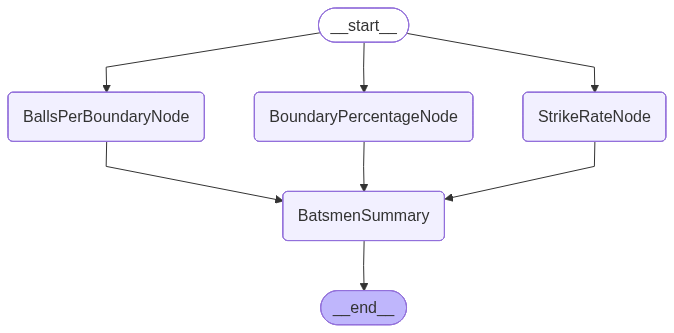

In [19]:
#compliling the workflow.
workflow = graph.compile()
workflow

In [20]:
#now initialing the CricketState schema
state = CricketState(
    runs = 68,
    total_ball_played_innings = 42,
    total_4s_innings = 7,
    total_6s_innings = 3
)
state

{'runs': 68,
 'total_ball_played_innings': 42,
 'total_4s_innings': 7,
 'total_6s_innings': 3}

In [21]:
#now invoking the workflow to start the execution of code.
result = workflow.invoke(input=state)
result

[2025-12-05 00:54:54,975]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'runs': 68,
 'total_ball_played_innings': 42,
 'total_4s_innings': 7,
 'total_6s_innings': 3,
 'strike_rate': 161.9,
 'boundary_perc': 67.65,
 'balls_per_boundary': 4.2,
 'summary': "Based on the provided metrics, this player is an aggressive and powerful batsman. Their high strike rate indicates they are capable of scoring quickly, taking advantage of loose deliveries and dominating the opposition. The boundary percentage suggests they are skilled at finding the gaps, often scoring boundaries with ease. This, combined with a relatively low balls per boundary ratio, implies they are a free-scoring batsman who can capitalize on any opportunity to hit big shots. Their aggressive approach is likely to put pressure on the opposition bowlers, making it challenging for them to contain the player's scoring."}

### UPSC Essay Evaluator LLM model want to Create

In [22]:
import operator
from typing import Optional
from pydantic import BaseModel,Field

In [23]:
#defining these parallel workflow schema that evaluating the Essay
class EssayEvaluationState(TypedDict):
    essay : str
    
    COT_feedback: Optional[str] = Field(None, description="Feedback for Clarity of Thought")
    DOA_feedback: Optional[str] = Field(None, description="Feedback for Depth of Analysis")
    LQ_feedback:  Optional[str] = Field(None, description="Feedback for Language Quality")
    
    final_feedback_essay :str| None
    
    # Reducer: collect all node scores in a list
    individual_score_each_nodes: Annotated[
        List[int], operator.add
    ] = Field(default_factory=list, description="Scores returned by multiple nodes, combined via reducer")
    
    final_score: Optional[float] = Field(None, ge=0, le=10, description="Final averaged score")
   

In [24]:
#creating an object of stategraph.
graph2 = StateGraph(state_schema=EssayEvaluationState)
graph2

In [25]:
#now defining the schema to get structure output from llm
class ClarityOfThoughtSchema(BaseModel):
    feedback: Annotated[
        str,
        Field(
            ...,
            description="Based on the essay text, evaluate the clarity of thought."
        )
    ]

    score: Annotated[
        int,
        Field(
            ...,
            description="Score clarity of thought between 1 to 10",
            gt=0,
            le=10
        )
    ]

In [26]:
class DepthOfAnalysisSchema(BaseModel):
    feedback: Annotated[
        str,
        Field(
            ...,
            description="Evaluate how deeply the essay explores the topic, including insight, reasoning, and critical analysis."
        )
    ]

    score: Annotated[
        int,
        Field(
            ...,
            description="Depth of analysis score between 1 to 10.",
            gt=0,
            le=10
        )
    ]


In [27]:
class LanguageQualitySchema(BaseModel):
    feedback: Annotated[
        str,
        Field(
            ...,
            description="Evaluate grammar, vocabulary, sentence structure, fluency, and overall language quality of the essay."
        )
    ]

    score: Annotated[
        int,
        Field(
            ...,
            description="Language quality score between 1 to 10.",
            gt=0,
            le=10
        )
    ]


In [28]:
#now defining the nodes that can perform 3 task
def COTNode(state:EssayEvaluationState)->EssayEvaluationState:
    #fetching the important key from state
    essay = state['essay']
    
    #wrapping llm with structure output.
    llm2 = model2.with_structured_output(schema=ClarityOfThoughtSchema)
    
    #dynamic user prompt converting into structure instruction prompt
    prompt = PromptTemplate(
        template="""
        You are an expert essay evaluator. Your task is to assess the **clarity of thought** in the given essay.

        Essay:
        "{essay}"

        Evaluation Instructions:
        - Analyze how clearly ideas are expressed
        - Check if arguments follow a logical flow
        - Identify whether the essay stays on topic
        - Detect ambiguity, confusion, or lack of coherence
        - Provide constructive, concise feedback

        Output Requirements:
        - Return feedback describing the clarity (2–4 sentences)
        - Return a score between **1 and 10** (higher = clearer)

        You MUST return output in the structure required by the schema.
            
        """,
        input_variables=['essay']
    )
    
    
    #forming the chain to execute the task.
    chain = prompt | llm2
    
    #invoking the chain to perform the task or action.
    result = chain.invoke(input={'essay':essay})
    
    
    return {
        'COT_feedback':result.feedback,
        'individual_score_each_nodes' :[result.score]
    }
    

In [29]:
#now defining the nodes that can perform 3 task
def DOANode(state:EssayEvaluationState)->EssayEvaluationState:
    #fetching the important key from state
    essay = state['essay']
    
    #wrapping llm with structure output.
    llm2 = model2.with_structured_output(schema=DepthOfAnalysisSchema)
    
    #dynamic user prompt converting into structure instruction prompt
    prompt = PromptTemplate(
        template="""
        You are an expert essay evaluator. Your task is to assess the **depth of analysis** in the following essay.

        Essay:
        "{essay}"

        Evaluation Instructions:
        - Evaluate how deeply the essay explores the topic
        - Check quality of reasoning, insight, and argument strength
        - Identify if the essay provides examples, evidence, or critical thinking
        - Look for meaningful interpretation rather than surface-level writing
        - Give constructive, objective feedback

        Output Requirements:
        - Provide feedback in 2–4 sentences
        - Give a score between **1 and 10** (higher = deeper analysis)
        - Return output strictly following the schema structure
                
        """,
        input_variables=['essay']
    )
    
    
    #forming the chain to execute the task.
    chain = prompt | llm2
    
    #invoking the chain to perform the task or action.
    result = chain.invoke(input={'essay':essay})
    
    
    return {
        'DOA_feedback':result.feedback,
        'individual_score_each_nodes':[result.score]
    }
    

In [30]:
#now defining the nodes that can perform 3 task
def LanguageEssayNode(state:EssayEvaluationState)->EssayEvaluationState:
    #fetching the important key from state
    essay = state['essay']
    
    #wrapping llm with structure output.
    llm2 = model2.with_structured_output(schema=LanguageQualitySchema)
    
    #dynamic user prompt converting into structure instruction prompt
    prompt = PromptTemplate(
        template="""
        You are an expert essay evaluator. Your task is to assess the **language quality** of the essay.

        Essay:
        "{essay}"

        Evaluation Instructions:
        - Evaluate grammar accuracy and sentence formation
        - Assess vocabulary strength and appropriateness
        - Check fluency, readability, and coherence
        - Identify awkward phrasing, structural issues, or ambiguity
        - Provide constructive and objective feedback

        Output Requirements:
        - Provide feedback in 2–4 sentences
        - Give a score between **1 and 10** (higher = better language quality)
        - Return output exactly in the schema format
        
        """,
        input_variables=['essay']
    )
    
    
    #forming the chain to execute the task.
    chain = prompt | llm2
    
    #invoking the chain to perform the task or action.
    result = chain.invoke(input={'essay':essay})
    
    
    return {
        'LQ_feedback':result.feedback,
        'individual_score_each_nodes':[result.score]
    }
    

In [31]:
class FinalEvaluationSchema(BaseModel):
    final_feedback: str
    average_score: float

In [32]:
def FinalEvaluationNode(state: EssayEvaluationState) -> EssayEvaluationState:
    
    clarity_feedback = state["COT_feedback"]
    

    depth_feedback = state['DOA_feedback']

    language_feedback = state['LQ_feedback']
    
    individual_score_each_nodes = state['individual_score_each_nodes']
    
    #calculating average score.
    avg_score = sum(individual_score_each_nodes)/len(individual_score_each_nodes)
    
    # Wrapped LLM for structured output
    llm_final = model1.with_structured_output(FinalEvaluationSchema)
    
    #creating structure instruction prompt.
    final_prompt = PromptTemplate(
        template="""
        You are an expert evaluator of essays. 

        Summarize the following feedback categories into a final holistic review:

        - **Clarity of Thought:** {clarity_feedback}
        - **Depth of Analysis:** {depth_feedback}
        - **Language Quality:** {language_feedback}

        The final average score for the essay is: {avg_score}

        Your task:
        - Merge all three feedbacks into a single coherent summary
        - Write a polished final evaluation in 4–6 lines
        - Do NOT repeat sentences; create a smooth integrated summary

        Return only the merged feedback paragraph.
        """,
        input_variables=[
            "clarity_feedback",
            "depth_feedback",
            "language_feedback",
            "avg_score"
        ]
    )
    
    
    chain = final_prompt | llm_final  # raw text output only
    
    response = chain.invoke({
        "clarity_feedback": clarity_feedback,
        "depth_feedback": depth_feedback,
        "language_feedback": language_feedback,
        "avg_score": avg_score
    })

    return {
        'final_feedback_essay':response.final_feedback,
        'final_score': response.average_score
    }

In [33]:
#connecting all the nodes and edges to orchestrate the Workflow.
graph2.add_node(node="COTNode",action=COTNode)
graph2.add_node(node="DOANode",action=DOANode)
graph2.add_node(node="LanguageEssayNode",action=LanguageEssayNode)


In [34]:
graph2.add_edge(START,"COTNode")
graph2.add_edge(START,"DOANode")
graph2.add_edge(START,"LanguageEssayNode")

In [35]:
graph2.add_node("FinalEvaluationNode",FinalEvaluationNode)

In [36]:
graph2.add_edge("COTNode","FinalEvaluationNode")
graph2.add_edge("DOANode","FinalEvaluationNode")
graph2.add_edge("LanguageEssayNode","FinalEvaluationNode")

In [37]:
graph2.add_edge("FinalEvaluationNode",END)

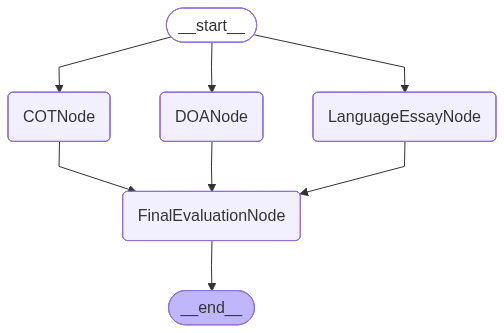

In [38]:
workflow2 = graph2.compile()
workflow2

In [39]:
text = '''
Artificial Intelligence (AI) is transforming the world,
and India is embracing this technology to solve real challenges.
Artificial intelligence is very much big thing. It make peoples life easy but also danger sometime. 
Many jobs going finish because machine do all work fastly. In future, AI maybe control human if not careful.
In healthcare, AI is helping doctors with faster diagnosis and better treatment decisions.
Rural telemedicine is supported by AI tools, improving access to medical services. 
Education in India is also being reshaped as AI provides personalized and adaptive learning experiences. 
Language translation systems are breaking barriers in India’s diverse linguistic landscape.
Farmers benefit from AI-driven crop monitoring, weather forecasting, and pest control.
In the financial sector, AI enhances fraud detection and risk management.
E-commerce platforms are using AI for smart recommendations and efficient logistics.
The Indian government is promoting AI through the Digital India mission. 
Aadhaar and UPI are examples of digital infrastructure enabling AI innovations. 
Startups across fintech, edtech, and healthtech are accelerating AI adoption. 
IT giants in India are developing advanced AI solutions for global markets. 
At the same time, ethical challenges such as bias, data privacy, and misuse must be addressed. 
Responsible AI policies are necessary for safe and fair use. 
Skill development programs are preparing India’s youth for AI-driven jobs. 
Affordable cloud services and open-source tools are fostering innovation. 
Partnerships between government, industry, and academia are boosting AI growth. 
India’s greatest strength is its ability to apply AI at scale to real-world problems. 
With balanced innovation and regulation, AI has the potential to transform India’s economy and society. 
The future of AI in India is both promising and impactful.




'''

In [40]:
#passing this initial state to graph or starting point.
intitial_state2 = EssayEvaluationState(
    essay=text
    
)
intitial_state2

{'essay': '\nArtificial Intelligence (AI) is transforming the world,\nand India is embracing this technology to solve real challenges.\nArtificial intelligence is very much big thing. It make peoples life easy but also danger sometime. \nMany jobs going finish because machine do all work fastly. In future, AI maybe control human if not careful.\nIn healthcare, AI is helping doctors with faster diagnosis and better treatment decisions.\nRural telemedicine is supported by AI tools, improving access to medical services. \nEducation in India is also being reshaped as AI provides personalized and adaptive learning experiences. \nLanguage translation systems are breaking barriers in India’s diverse linguistic landscape.\nFarmers benefit from AI-driven crop monitoring, weather forecasting, and pest control.\nIn the financial sector, AI enhances fraud detection and risk management.\nE-commerce platforms are using AI for smart recommendations and efficient logistics.\nThe Indian government is p

In [41]:
result = workflow2.invoke(intitial_state2)
result

[2025-12-05 00:54:55,637]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
[2025-12-05 00:54:55,645]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
[2025-12-05 00:54:55,650]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


c:\anaconda\envs\hf-gpu\lib\site-packages\langchain_openai\chat_models\base.py:1906: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


[2025-12-05 00:54:58,226]-_client.py-INFO -HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'essay': '\nArtificial Intelligence (AI) is transforming the world,\nand India is embracing this technology to solve real challenges.\nArtificial intelligence is very much big thing. It make peoples life easy but also danger sometime. \nMany jobs going finish because machine do all work fastly. In future, AI maybe control human if not careful.\nIn healthcare, AI is helping doctors with faster diagnosis and better treatment decisions.\nRural telemedicine is supported by AI tools, improving access to medical services. \nEducation in India is also being reshaped as AI provides personalized and adaptive learning experiences. \nLanguage translation systems are breaking barriers in India’s diverse linguistic landscape.\nFarmers benefit from AI-driven crop monitoring, weather forecasting, and pest control.\nIn the financial sector, AI enhances fraud detection and risk management.\nE-commerce platforms are using AI for smart recommendations and efficient logistics.\nThe Indian government is p